**Workflow: P/PET Average in April vs. in April 2020**

- connect to aWhere's API
- call ppet for April 2020 for test area (Yreka)
 - may have to make multiple requests
 - join data into 1 main dataframe
- get ppet for April 2019 for same site
- find difference in values and save to df
- call ppet for each site in grid geodataframe

In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

import geopandas as gpd
import earthpy as et

import requests as rq

from header import AWhereAPI
from secret_codes import *

In [2]:
# Import codes from secret_codes.py
api_key = API_KEY
api_secret = API_SECRET

In [3]:
# Create aWhere object
aw = AWhereAPI(api_key, api_secret)

# To get auth token, encode secret and key
sc = aw.encode_secret_and_key(API_KEY, API_SECRET)

# Then call auth token
token = aw.get_oauth_token(sc)

# Set up headers: auth and specific header for agronomics data
auth_headers = {"Authorization": "Bearer %s" % token,
                "Content-Type": 'application/json'}

agro_header = {"Authorization":  "Bearer %s" % token}

# General aWhere API endpoint "prefix"
endpt = "https://api.awhere.com"

In [4]:
# Function to fetch agronomic norms json
# given lat, long, start, end day (can include year)
def agro_json(start_day, end_day, latitude, longitude, search_type):

    hist_ag_url = f"/v2/agronomics/locations/{latitude},{longitude}/agronomic{search_type}/{start_day},{end_day}"
    
    ag_norms_period = rq.get((endpt + hist_ag_url), headers=agro_header).json()
    
    return ag_norms_period

In [5]:
# Return average ppet for April

# Set lat and long
latitude = 41.726667
longitude = -122.6375

# Each JSON covers 10 days
days_dict = {1: ["04-01", "04-10"],
             2: ["04-11", "04-20"],
            3: ["04-21", "04-30"]}

# List to hold all returned JSONs (3 here)
json_list = []

# Loop thru keys and get JSONs for specified date ranges
for key in days_dict.keys():
    
    # Extract first and last days in range from dict 
    start_day = days_dict[key][0]
    end_day = days_dict[key][1]
    
    # Get json
    period_json = agro_json(start_day, end_day, latitude, longitude, "norms")
    
    # Add json to list of JSONs
    json_list.append(period_json)

In [6]:
# Will be a list of lists, with each sublist holding a "row"
master_list = []


for period_json in json_list:

    # For each day in all days in json
    for day in range(0, len(period_json['dailyNorms'])):

        # List to hold values from specific day
        day_list = []
        
        # Add date
        day_list.append(period_json['dailyNorms'][day].get('day'))

        # Add average ppet
        day_list.append(period_json['dailyNorms'][day].get('ppet').get('average'))

        # Add ppet stddev
        day_list.append(period_json['dailyNorms'][day].get('ppet').get("stdDev"))
        
        # Add list to "list of lists"
        master_list.append(day_list)

# Convert master list to dataframe
ppet_april_norms = pd.DataFrame(master_list, columns=['day', 'avg', 'std'])

In [7]:
# Get April 2020 agronomic values

# Location for Yreka, CA
latitude = 41.726667
longitude = -122.6375

# Dates for April 2020
dates_dict = {1: ["2020-04-01", "2020-04-10"],
              2: ["2020-04-11", "2020-04-20"],
              3: ["2020-04-21", "2020-04-30"]}

# Holds all  returned JSONs 
json_list = []

for key in days_dict.keys():

    start_date = days_dict[key][0]
    end_date = days_dict[key][1]

    april_2020_json = agro_json(
        start_date, end_date, latitude, longitude, "values")

    json_list.append(april_2020_json)

# Holds all rows for all JSONs
master_list = []

for period_json in json_list:

    # For each day in all days in json
    for day in range(0, len(period_json['dailyValues'])):

        # List to hold values from specific day
        day_list = []

        day_list.append(period_json['dailyValues'][day].get('date'))

        # Get average ppet
        day_list.append(period_json['dailyValues'][day].get('ppet'))

        master_list.append(day_list)
        
ppet_april_2020 = pd.DataFrame(master_list, columns=['day', 'ppet'])

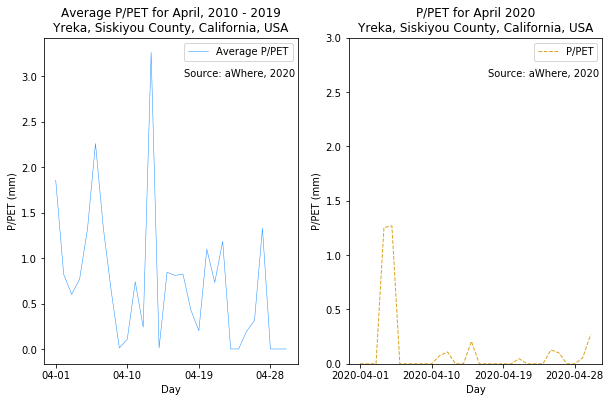

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,6))

# Set labels and title
ax1.set(title="Average P/PET for April, 2010 - 2019\n" +
       "Yreka, Siskiyou County, California, USA",
       xlabel="Day",
       ylabel="P/PET (mm)")

# Create plot of average P/PET
ax1.plot(ppet_april_norms.day, ppet_april_norms.avg, label="Average P/PET", linewidth=0.5, color='dodgerblue')

# Set ticker at regular intervals
tic = plticker.MultipleLocator(base=9.0)
ax1.xaxis.set_major_locator(tic)

# Show legend
ax1.legend()

# Add source info
ax1.text(0.55, 0.88, transform=ax1.transAxes, s="Source: aWhere, 2020")

"""Plot 2: This April"""
# Set labels and title
ax2.set(title="P/PET for April 2020\n" +
       "Yreka, Siskiyou County, California, USA",
       xlabel="Day",
       ylabel="P/PET (mm)")

# Create plot of average P/PE8
ax2.plot(ppet_april_2020.day, ppet_april_2020.ppet, label="P/PET", linewidth=1, color='goldenrod', linestyle='--')

# Set ticker at regular intervals
tic = plticker.MultipleLocator(base=9.0)
ax2.xaxis.set_major_locator(tic)

# Show legend
ax2.legend()

# Add source info
ax2.text(0.55, 0.88, transform=ax2.transAxes, s="Source: aWhere, 2020")

# Set axes to be the same
plt.ylim(0, 3)
plt.gca().set_aspect(aspect='auto', adjustable='box')

plt.show()

**Grid code below**

In [10]:
# Create path to grid geojson
grid_path = os.path.join(et.io.HOME, "Desktop", "drought", "data", "created", "aoi_polys.geojson")

# Read as gdf
aoi_grid = gpd.read_file(grid_path)

# Add centroid column 
aoi_grid['centroid'] = aoi_grid.geometry.apply(lambda poly: poly.centroid)

# add ppet column with values of 0 
aoi_grid = aoi_grid.assign(ppet = 0)

In [13]:
aoi_grid = aoi_grid[:2]

In [16]:
# Pass in month and year
start_day = "2020-04-01"
end_day = "2020-04-30"

for index, row in aoi_grid.iterrows():
    
    # Get lat and long from grid
    latitude = row.centroid.y
    longitude = row.centroid.x
    
    # Get and parse json
    hist_ag_url = f"/v2/agronomics/locations/{latitude},{longitude}/agronomicvalues/{start_day},{end_day}"
    
    # Endpoint suffix to get all accumulations
    ppet_append = "?properties=accumulations"
    
    # Get JSON
    ag_norms_period = rq.get((endpt + hist_ag_url + ppet_append), headers=agro_header).json()

    # Add accumulated ppet for April 2020
    aoi_grid.loc[index, 'ppet'] = ag_norms_period.get('accumulations').get('ppet')

In [17]:
# Create path to area of interest for plotting
aoi_path = os.path.join(et.io.HOME, "desktop", "drought", "data", "created", "aoi.shp")

# Create path to county boundaries for plotting
county_path = os.path.join(et.io.HOME, "desktop", "drought", "data", "TIGER", "cb_2018_us_county_500k.shp")

# Load all CA counties
counties = gpd.read_file(county_path)

# Select Siskyou county
siskiyou = counties[counties.NAME == 'Siskiyou']

# Load AoI into gdf
aoi = gpd.read_file(aoi_path)

In [20]:
aoi_grid

,geometry,centroid,ppet
0,"POLYGON ((-123.85503 40.97764, -123.77503 40.9...",POINT (-123.81503 41.01764),14.924904
1,"POLYGON ((-123.85503 41.05764, -123.77503 41.0...",POINT (-123.81503 41.09764),12.198133


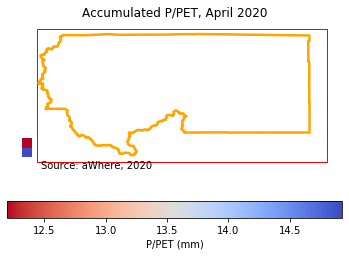

In [18]:
fig, ax = plt.subplots()

ax.set(title="Accumulated P/PET, April 2020")

aoi_grid.plot(column='ppet', ax=ax, cmap='coolwarm_r', legend=True,
             legend_kwds={'label': "P/PET (mm)", 'orientation': "horizontal"})

aoi.plot(ax=ax, color="none", edgecolor="red")

siskiyou.plot(ax=ax, color="none", edgecolor="orange", linewidth=2.5)

ax.set_axis_off()

ax.text(0.1, 0.00001, transform=ax.transAxes, s="Source: aWhere, 2020")

plt.show()